In [ ]:
import gdown
import pandas as pd
import numpy as np
import tempfile
import json
import pyspark
import requests
from pyspark.sql import SparkSession
from shapely.geometry import Point
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, StructType, StructField, IntegerType, FloatType, StringType, BinaryType, ArrayType
from pyproj import Transformer
from pyspark.sql.window import Window


In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
        .master('local[*]')
        .appName('Spark Tutorial')
        .config('spark.ui.port', '4040')
        .getOrCreate()
        )

spark

# Download Data

In [ ]:
url = "https://drive.google.com/uc?id=19QkF8i1my99gjbyHe7de_qZNwgrca6R5"
output = "bangkok_traffy.csv"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19QkF8i1my99gjbyHe7de_qZNwgrca6R5
From (redirected): https://drive.google.com/uc?id=19QkF8i1my99gjbyHe7de_qZNwgrca6R5&confirm=t&uuid=59e511f0-9d45-4001-9098-f63f7706a7f4
To: /content/bangkok_traffy.csv
100%|██████████| 1.07G/1.07G [00:10<00:00, 97.9MB/s]


'bangkok_traffy.csv'

In [ ]:
manual_schema = StructType([
    StructField("ticket_id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("organization", StringType(), True),
    StructField("comment", StringType(), True),
    StructField("photo", StringType(), True),
    StructField("photo_after", StringType(), True),
    StructField("coords", StringType(), True),
    StructField("address", StringType(), True),
    StructField("subdistrict", StringType(), True),
    StructField("district", StringType(), True),
    StructField("province", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("state", StringType(), True),
    StructField("star", FloatType(), True),
    StructField("count_reopen", IntegerType(), True),
    StructField("last_activity", StringType(), True),
])

In [ ]:
df = spark.read.csv(output, header=True, sep=',', quote='"', escape='"', multiLine=True, schema=manual_schema)
print(df.count())

787026


In [ ]:
df

DataFrame[ticket_id: string, type: string, organization: string, comment: string, photo: string, photo_after: string, coords: string, address: string, subdistrict: string, district: string, province: string, timestamp: string, state: string, star: float, count_reopen: int, last_activity: string]

In [ ]:
(df.count(), len(df.columns))

(787026, 16)

In [ ]:
# Drop unused columns
cols_to_drop = [
    'photo', 'photo_after', 'address',
    'province', 'star', 'last_activity', 'organization',
    'state', 'type', 'subdistrict'
]

df = df.drop(*cols_to_drop)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Drop missing comment
df = df.filter(F.col('comment').isNotNull())

df = df.withColumn('comment', F.trim(F.col('comment').cast("string")))

# Drop empty comment
df = df.filter(F.length(F.col('comment')) > 0)

In [ ]:
# Standardize timestamp
df = df.withColumn('timestamp', F.to_timestamp(F.col('timestamp')))

# Drop invalid timestamp
df = df.filter(F.col('timestamp').isNotNull())

# Year 2022
df = df.filter(F.year(F.col('timestamp')) == 2022)

In [ ]:
df = df.dropDuplicates()


In [ ]:
df.show(5)

+--------------------+------------------+--------------------+------------+
|             comment|            coords|           timestamp|count_reopen|
+--------------------+------------------+--------------------+------------+
|          จุดทิ้งขยะ|100.52683,13.70816|2022-02-16 11:44:...|           0|
|คนสติไม่ดีนอนริมท...|100.48597,13.73732|2022-05-11 01:36:...|           0|
|ฟุตบาทบริเวณหน้าโ...|100.63938,13.66730|2022-05-29 11:42:...|           0|
|อยากให้ทำทั่วกรุง...|100.50102,13.75514|2022-05-29 14:07:...|           0|
|เขตคลองเตย ทางเดิ...|100.56505,13.72742|2022-05-29 23:24:...|           1|
+--------------------+------------------+--------------------+------------+
only showing top 5 rows



In [ ]:
# df[['lng', 'lat']] = df['coords'].str.split(',', expand=True).astype(float)
df = df.withColumn('lng_str', F.split(F.col('coords'), ',').getItem(0)) \
       .withColumn('lat_str', F.split(F.col('coords'), ',').getItem(1))
# geometry = [Point(xy) for xy in zip(df['lng'], df['lat'])]
# df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

df = df.withColumn('lng', F.col('lng_str').cast(DoubleType())) \
       .withColumn('lat', F.col('lat_str').cast(DoubleType()))

# Drop coords
# df = df.drop(columns=["coords"], errors='ignore')
df = df.drop('coords', 'lng_str', 'lat_str')

# display(df.head())
df.show(5)

+-----------+--------------------+--------+--------------------+------------+---------+--------+
|  ticket_id|             comment|district|           timestamp|count_reopen|      lng|     lat|
+-----------+--------------------+--------+--------------------+------------+---------+--------+
|2022-44BXP6|<แจ้งเรื่องซ่อมป้...|    สาทร|2022-05-29 13:17:...|           0|100.53627|13.70651|
|2022-CDGZZU|รูปที่ 2 จะเห็นว่...| สวนหลวง|2022-05-29 13:31:...|           0|100.61452|13.72238|
|2022-99FG2D|ประเภท การจราจรบน...| ยานนาวา|2022-05-30 03:06:...|           0|100.54277|13.70219|
|2022-3Z8C6M|ตรงป้ายรถเมล์หน้า...| จตุจักร|2022-05-30 09:43:...|           0|100.57303|13.83527|
|2022-MRRPHD|ถนนลาดปลาเค้า เลี...|  บางเขน|2022-05-30 12:45:...|           0|100.61353|13.86299|
+-----------+--------------------+--------+--------------------+------------+---------+--------+
only showing top 5 rows



In [ ]:
# ลองจิจูด
min_lng, max_lng = 100.45, 101
# ละติจูด
min_lat, max_lat = 13.55, 13.95

df = df.filter(
    (col("lng") >= min_lng) & (col("lng") <= max_lng) &
    (col("lat") >= min_lat) & (col("lat") <= max_lat)
)
df.count()

167565

In [ ]:
(df.count(), len(df.columns))

(167565, 7)

In [ ]:
cleaned_df = df

# จำนวนแถว
print("Number of rows:", cleaned_df.count())

# จำนวนคอลัมน์
print("Number of columns:", len(cleaned_df.columns))

# schema ของแต่ละคอลัมน์
cleaned_df.printSchema()

# สรุป non-null ของแต่ละคอลัมน์
from pyspark.sql.functions import col, count

cleaned_df.select([count(col(c)).alias(c) for c in cleaned_df.columns]).show()

Number of rows: 167565
Number of columns: 7
root
 |-- ticket_id: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- district: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- count_reopen: integer (nullable = true)
 |-- lng: double (nullable = true)
 |-- lat: double (nullable = true)

+---------+-------+--------+---------+------------+------+------+
|ticket_id|comment|district|timestamp|count_reopen|   lng|   lat|
+---------+-------+--------+---------+------------+------+------+
|   167565| 167565|  167530|   167565|      167565|167565|167565|
+---------+-------+--------+---------+------------+------+------+



In [ ]:
columns_to_check = cleaned_df.columns

null_counts_expr = [
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in columns_to_check
]

null_counts_df = cleaned_df.select(null_counts_expr)
null_counts_df.show(truncate=False)


+---------+-------+--------+---------+------------+---+---+
|ticket_id|comment|district|timestamp|count_reopen|lng|lat|
+---------+-------+--------+---------+------------+---+---+
|0        |0      |35      |0        |0           |0  |0  |
+---------+-------+--------+---------+------------+---+---+



## count_reopen

In [ ]:
percentiles = [0.90, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]

percentile_expr = F.percentile_approx(
    F.col("count_reopen"),
    F.array([F.lit(p) for p in percentiles]),
    100000
).alias("percentile_values")

percentile_df = cleaned_df.select(percentile_expr)

percentile_df.show(truncate=False)

+---------------------+
|percentile_values    |
+---------------------+
|[0, 1, 1, 1, 2, 3, 5]|
+---------------------+



In [ ]:
import matplotlib.pyplot as plt

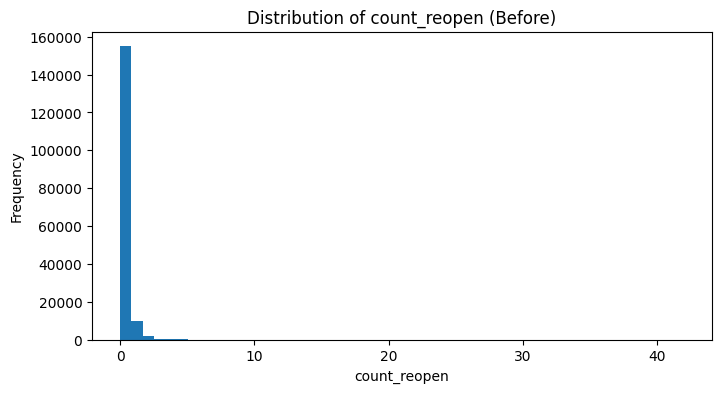

In [ ]:
# ดึงคอลัมน์จาก Spark DF มาเป็น pandas Series
count_reopen_pd = cleaned_df.select("count_reopen").toPandas()

plt.figure(figsize=(8,4))
plt.hist(count_reopen_pd['count_reopen'], bins=50)
plt.title("Distribution of count_reopen (Before)")
plt.xlabel("count_reopen")
plt.ylabel("Frequency")
plt.show()

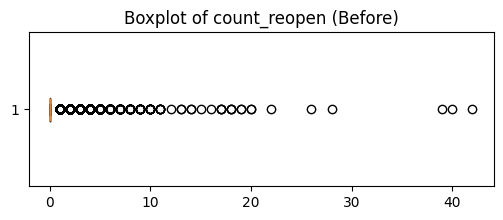

In [ ]:
count_reopen_pd = cleaned_df.select("count_reopen").toPandas()

plt.figure(figsize=(6,2))
plt.boxplot(count_reopen_pd['count_reopen'], vert=False)
plt.title("Boxplot of count_reopen (Before)")
plt.show()

In [ ]:
cleaned_df = cleaned_df.withColumn(
    "count_reopen_log",
    F.log1p(col("count_reopen"))
)

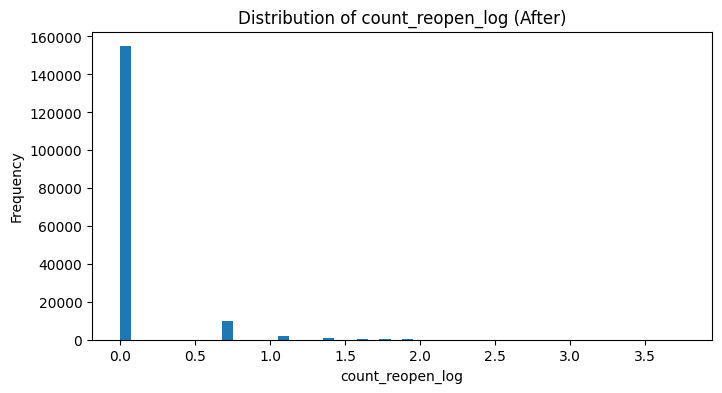

In [ ]:
count_reopen_log_pd = cleaned_df.select("count_reopen_log").toPandas()

plt.figure(figsize=(8,4))
plt.hist(count_reopen_log_pd['count_reopen_log'], bins=50)
plt.title("Distribution of count_reopen_log (After)")
plt.xlabel("count_reopen_log")
plt.ylabel("Frequency")
plt.show()

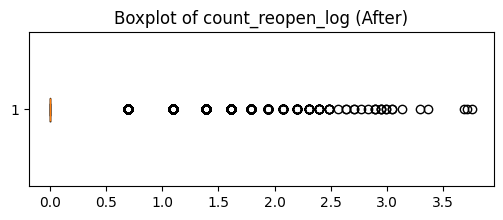

In [ ]:
count_reopen_log_pd = cleaned_df.select("count_reopen_log").toPandas()

plt.figure(figsize=(6,2))
plt.boxplot(count_reopen_log_pd['count_reopen_log'], vert=False)
plt.title("Boxplot of count_reopen_log (After)")
plt.show()

In [ ]:
percentiles = [0.90, 0.95, 0.97, 0.98, 0.99, 0.995, 0.999]

result = cleaned_df.approxQuantile(
    "count_reopen",
    percentiles,
    0.0   # relative error = 0 (exact)
)

print(result)


[0.0, 1.0, 1.0, 1.0, 2.0, 3.0, 5.0]


In [ ]:
cleaned_df.select(F.skewness("count_reopen")).show()
cleaned_df.select(F.skewness("count_reopen_log")).show()

+----------------------+
|skewness(count_reopen)|
+----------------------+
|     17.98594422106058|
+----------------------+

+--------------------------+
|skewness(count_reopen_log)|
+--------------------------+
|         4.229932940308557|
+--------------------------+



In [ ]:
num_rows = cleaned_df.count()
num_cols = len(cleaned_df.columns)
print("Shape:", (num_rows, num_cols))

Shape: (167565, 8)


In [ ]:
cleaned_df.show(20)

+-----------+--------------------+---------+--------------------+------------+---------+--------+------------------+
|  ticket_id|             comment| district|           timestamp|count_reopen|      lng|     lat|  count_reopen_log|
+-----------+--------------------+---------+--------------------+------------+---------+--------+------------------+
|2022-44BXP6|<แจ้งเรื่องซ่อมป้...|     สาทร|2022-05-29 13:17:...|           0|100.53627|13.70651|               0.0|
|2022-CDGZZU|รูปที่ 2 จะเห็นว่...|  สวนหลวง|2022-05-29 13:31:...|           0|100.61452|13.72238|               0.0|
|2022-99FG2D|ประเภท การจราจรบน...|  ยานนาวา|2022-05-30 03:06:...|           0|100.54277|13.70219|               0.0|
|2022-3Z8C6M|ตรงป้ายรถเมล์หน้า...|  จตุจักร|2022-05-30 09:43:...|           0|100.57303|13.83527|               0.0|
|2022-MRRPHD|ถนนลาดปลาเค้า เลี...|   บางเขน|2022-05-30 12:45:...|           0|100.61353|13.86299|               0.0|
|2022-DZLEZB|สายไฟไม่เป็นระเบี...|    พญาไท|2022-05-30 18:41:...

In [ ]:
for col_name in cleaned_df.columns:
    print(col_name)


ticket_id
comment
district
timestamp
count_reopen
lng
lat
count_reopen_log


# Web scraping
impact_to_public

In [ ]:
# Department Store

url_department = "https://data.bangkok.go.th/dataset/d8f814ac-cbaf-43c3-9576-f533b2554776/resource/438101c3-5535-4fe2-bc5e-83aa73703d4a/download/department_store.csv"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url_department, headers=headers)
response.raise_for_status()

with tempfile.NamedTemporaryFile(delete=False, suffix=".csv") as tmp:
    tmp.write(response.content)
    temp_path = tmp.name

df_department = spark.read.csv(temp_path, header=True, inferSchema=True)
df_department =df_department.select( "name","lat", "lng",)

df_department.printSchema()
df_department.show(5)

root
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)

+--------------------+-----------+-----------+
|                name|        lat|        lng|
+--------------------+-----------+-----------+
|บิ๊กซี สาขาสุขาภิ...| 13.7708549|100.6583974|
|  โลตัส จรัญสนิทวงศ์|13.78792845|100.5023849|
|     โลตัส แจ้งวัฒนะ|13.89582877|100.5561529|
|   โลตัส ซีคอนสแควร์|13.69253958|100.6480293|
|         โลตัส บางแค|13.71265311|100.4189684|
+--------------------+-----------+-----------+
only showing top 5 rows



In [ ]:
# Community
url_community = "https://cpudgiapp.bangkok.go.th/arcgis/rest/services/Community/Service_Community_Public/MapServer/0/query"
params = {
    "where": "1=1",
    "outFields": "*",
    "f": "json",
    "returnGeometry": "true"
}
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url_community, headers=headers, params=params)
response.raise_for_status()
data = response.json()

features = [f["attributes"] for f in data["features"]]

with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".json") as tmp:
    for feature in features:
        tmp.write(json.dumps(feature) + "\n")
    temp_path = tmp.name

df_community = spark.read.json(temp_path)
df_community = df_community.select("CMT_NAME", "LAT", "LON")
df_community.printSchema()
df_community.show(5)


root
 |-- CMT_NAME: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)

+----------------+-----------+------------+
|        CMT_NAME|        LAT|         LON|
+----------------+-----------+------------+
|   เกาะกลางพัฒนา|13.84526077|100.90390687|
| หมู่บ้านจามจุรี| 13.8489477|100.88314161|
|ป.เจริญมิตรพัฒนา|13.82229231|100.92422042|
|  ลำสลิดทองพัฒนา|13.83784223|100.87353488|
| นันทวันเซ็นต์ 1|13.84445163|100.88276877|
+----------------+-----------+------------+
only showing top 5 rows



In [ ]:
#school
url_school = "https://bmagis.bangkok.go.th/arcgis/rest/services/riskbkk/RISK_ADMIN_bma_school/FeatureServer/0/query"

params = {
    "where": "1=1",
    "outFields": "*",
    "f": "json",
    "returnGeometry": "true"
}
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url_school, headers=headers, params=params)
response.raise_for_status()
data = response.json()

features = [f["attributes"] for f in data["features"]]

with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".json") as tmp:
    for feature in features:
        tmp.write(json.dumps(feature) + "\n")
    temp_path = tmp.name

df_school= spark.read.json(temp_path)


df_school.printSchema()
df_school.show(5)


root
 |-- ADDRESS: string (nullable = true)
 |-- CREATED_DATE: long (nullable = true)
 |-- CREATED_USER: string (nullable = true)
 |-- DCODE: string (nullable = true)
 |-- GLOBALID: string (nullable = true)
 |-- LAST_EDITED_DATE: long (nullable = true)
 |-- LAST_EDITED_USER: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- OBJECTID: long (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)

+--------------------+------------+------------+-----+--------------------+----------------+----------------+--------------------+--------+----+----------+-----------+
|             ADDRESS|CREATED_DATE|CREATED_USER|DCODE|            GLOBALID|LAST_EDITED_DATE|LAST_EDITED_USER|                NAME|OBJECTID|TYPE|         X|          Y|
+--------------------+------------+------------+-----+--------------------+----------------+----------------+--------------------+--------+----+----------+-----------+
|132 ถ.สามเสน แขวง

In [ ]:
# Hospital
url_hospital = "https://bmagis.bangkok.go.th/arcgis/rest/services/riskbkk/RISK_ADMIN_Hospital/FeatureServer/0/query"

# ใช้พารามิเตอร์เหมือน Community/School
params = {
    "where": "1=1",
    "outFields": "*",
    "f": "json",
    "returnGeometry": "true"
}
headers = {"User-Agent": "Mozilla/5.0"}

# ดึงข้อมูล JSON
response = requests.get(url_hospital, headers=headers, params=params)
response.raise_for_status()
data_hospital = response.json()

# Extract attributes
features = [f["attributes"] for f in data_hospital["features"]]

# บันทึกเป็นไฟล์ชั่วคราว JSON Lines (เหมือน CSV ใน pattern เดิม)
with tempfile.NamedTemporaryFile(mode="w", delete=False, suffix=".json") as tmp:
    for feature in features:
        tmp.write(json.dumps(feature) + "\n")
    temp_path = tmp.name

# โหลดเข้า Spark
df_hospital = spark.read.json(temp_path)
df_hospital.printSchema()
df_hospital.show(5)

root
 |-- ADDRESS: string (nullable = true)
 |-- DCODE: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- NUM_BED: long (nullable = true)
 |-- OBJECTID: long (nullable = true)
 |-- TEL: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)

+--------------------+-----+--------------------+-------+--------+------------------+----------+-----------+
|             ADDRESS|DCODE|                NAME|NUM_BED|OBJECTID|               TEL|         X|          Y|
+--------------------+-----+--------------------+-------+--------+------------------+----------+-----------+
|171 ถ.พหลโยธิน แข...| 1042|โรงพยาบาลภูมิพลอด...|    700|       1|     0 - 2534-7000|674848.512|1538263.349|
|312 ถ. ราชวิถี แข...| 1037|โรงพยาบาลและสถาบั...|    350|       2|   0 - 2246 - 9254|665118.241|1522693.716|
|315 ถ.ราชวิถี ทุ่...| 1037|โรงพยาบาลพระมงกุฏ...|   1236|       3|0 - 2246 - 1400-28|665789.636|1522522.013|
|2 ถ.พญาไท แขวงทุ่...| 1037|    โรงพยาบาลราชวิถี|   

In [ ]:
from pyspark.sql import functions as F
def clean_and_convert_to_gdf(df, col_map, place_type, drop_zero=True):
    # Step 1: select & rename
    df_clean = df.select(
        F.col(col_map["name"]).alias("name"),
        F.col(col_map["lat"]).alias("lat"),
        F.col(col_map["lng"]).alias("lng")
    )

    # Step 2: clean name
    df_clean = df_clean.withColumn("name", F.trim(F.col("name").cast(StringType())))
    df_clean = df_clean.filter((F.col("name").isNotNull()) & (F.col("name") != ""))

    # Step 3: convert numeric
    df_clean = df_clean.withColumn("lat", F.col("lat").cast(DoubleType()))
    df_clean = df_clean.withColumn("lng", F.col("lng").cast(DoubleType()))

    # Step 4: drop missing / zero
    df_clean = df_clean.filter(F.col("lat").isNotNull() & F.col("lng").isNotNull())
    if drop_zero:
        df_clean = df_clean.filter((F.col("lat") != 0) & (F.col("lng") != 0))

    # Step 5: detect coordinate system
    max_lat = df_clean.agg(F.max("lat")).collect()[0][0]

    if max_lat > 1000:
        # เป็น UTM → ต้อง convert เป็น WGS84
        print(f"[{place_type}] Detected UTM coordinates → converting to WGS84...")

        transformer = Transformer.from_crs("EPSG:32647", "EPSG:4326", always_xy=True)

        def utm_to_wgs84(lng, lat):
            x, y = transformer.transform(lng, lat)
            return float(y), float(x)

        schema = StructType([
            StructField("lat", DoubleType(), True),
            StructField("lng", DoubleType(), True)
        ])
        convert_udf = F.udf(utm_to_wgs84, schema)
        df_clean = df_clean.withColumn("coords", convert_udf(F.col("lng"), F.col("lat")))
        df_clean = df_clean.withColumn("lat", F.col("coords.lat")).withColumn("lng", F.col("coords.lng"))
        df_clean = df_clean.drop("coords")

    # Step 6: create geometry column (WKT)
    # df_clean = df_clean.withColumn("geometry", F.concat(F.lit("POINT("), F.col("lng"), F.lit(" "), F.col("lat"), F.lit(")")))

    # Step 7: add type column
    df_clean = df_clean.withColumn("type", F.lit(place_type))

    return df_clean

In [ ]:
column_mapping = {
    "department": {"name": "name", "lat": "lat", "lng": "lng"},
    "community":  {"name": "CMT_NAME", "lat": "LAT",  "lng": "LON"},
    "school":     {"name": "NAME",     "lat": "Y",    "lng": "X"},
    "hospital":   {"name": "NAME",     "lat": "Y",    "lng": "X"},
}


In [ ]:
gdf_department = clean_and_convert_to_gdf(
    df_department, column_mapping["department"], "department"
)

gdf_community = clean_and_convert_to_gdf(
    df_community,  column_mapping["community"],  "community"
)

gdf_school = clean_and_convert_to_gdf(
    df_school,     column_mapping["school"],     "school"
)

gdf_hospital = clean_and_convert_to_gdf(
    df_hospital,   column_mapping["hospital"],   "hospital"
)
gdf_hospital.show()

[school] Detected UTM coordinates → converting to WGS84...
[hospital] Detected UTM coordinates → converting to WGS84...
+--------------------+------------------+------------------+--------+
|                name|               lat|               lng|    type|
+--------------------+------------------+------------------+--------+
|โรงพยาบาลภูมิพลอด...| 13.90906761524505|100.61827997441632|hospital|
|โรงพยาบาลและสถาบั...|13.768916200376625|100.52732768961256|hospital|
|โรงพยาบาลพระมงกุฏ...| 13.76732560190235| 100.5335263386532|hospital|
|    โรงพยาบาลราชวิถี|13.764685552609794|100.53591579510122|hospital|
|       โรงพยาบาลสงฆ์|13.762010103172393|100.52658651387576|hospital|
|สถาบันกัลยาณ์ราชน...|  13.7629426217558|100.33088905414687|hospital|
|  โรงพยาบาลราชานุกูล|13.761351779909493|100.55458487772259|hospital|
|โรงพยาบาลบุรฉัตรไ...|13.752014519501508| 100.5516604606358|hospital|
|      โรงพยาบาลตำรวจ|13.742668977310746|100.53936885694073|hospital|
| โรงพยาบาลจุฬาลงกรณ์|13.730927156861929

In [ ]:
# รวมทุกประเภทเป็น DataFrame เดียว
gdf_public_place = gdf_department\
    .unionByName(gdf_community) \
    .unionByName(gdf_school) \
    .unionByName(gdf_hospital)

# นับจำนวนแถวทั้งหมด
print("Total public places:", gdf_public_place.count())
windowSpec = Window.orderBy(F.monotonically_increasing_id())
gdf_public_place = gdf_public_place.withColumn("index", F.row_number().over(windowSpec))
cols = gdf_public_place.columns  # ดึงชื่อคอลัมน์ทั้งหมด
cols.remove("index")             # ลบ index ออกจาก list
cols = ["index"] + cols          # นำ index มาไว้ด้านหน้า

# เลือกคอลัมน์ตามลำดับใหม่
gdf_public_place = gdf_public_place.select(*cols)

gdf_public_place.show()
# แสดงตัวอย่าง 5 แถวแรก




Total public places: 1718
+-----+--------------------+-----------+-----------+----------+
|index|                name|        lat|        lng|      type|
+-----+--------------------+-----------+-----------+----------+
|    1|บิ๊กซี สาขาสุขาภิ...| 13.7708549|100.6583974|department|
|    2|  โลตัส จรัญสนิทวงศ์|13.78792845|100.5023849|department|
|    3|     โลตัส แจ้งวัฒนะ|13.89582877|100.5561529|department|
|    4|   โลตัส ซีคอนสแควร์|13.69253958|100.6480293|department|
|    5|         โลตัส บางแค|13.71265311|100.4189684|department|
|    6|       โลตัส บางกะปิ|13.76830395|100.6438702|department|
|    7|      โลตัส บางปะกอก|13.67783388|100.5014712|department|
|    8|     โลตัส ประชาชื่น|13.80596243|100.5344849|department|
|    9|      โลตัส พระราม 2|13.64782946|100.4188943|department|
|   10|      โลตัส พระราม 3|13.69649021|100.5413436|department|
|   11|      โลตัส พระราม 4|13.71699232|100.5684751|department|
|   12|       โลตัส มีนบุรี|13.81684745|100.7286552|department|
|   13|  โลตัส

In [ ]:
gdf_public_place.sample(fraction=0.01, seed=42).show(5, truncate=False)

+-----+-----------------------+------------------+------------------+---------+
|index|name                   |lat               |lng               |type     |
+-----+-----------------------+------------------+------------------+---------+
|256  |พระยาประสิทธิ์         |13.78832473       |100.52091582      |community|
|314  |หมู่บ้านศรัณจิต 1      |13.6894374        |100.63428343      |community|
|396  |มหาดไทย 2              |13.76703204       |100.63159259      |community|
|713  |ซอยประชาร่วมใจ         |13.747439         |100.46608326      |community|
|1183 |โรงเรียนสุเหร่าลาดพร้าว|13.771573761164296|100.59413243554145|school   |
+-----+-----------------------+------------------+------------------+---------+
only showing top 5 rows



In [ ]:
cleaned_df = cleaned_df.withColumn("index", F.row_number().over(windowSpec))
cols = cleaned_df.columns  # ดึงชื่อคอลัมน์ทั้งหมด
cols.remove("index")             # ลบ index ออกจาก list
cols = ["index"] + cols          # นำ index มาไว้ด้านหน้า

# เลือกคอลัมน์ตามลำดับใหม่
cleaned_df = cleaned_df.select(*cols)

cleaned_df.show()

+-----+-----------+--------------------+---------+--------------------+------------+---------+--------+------------------+
|index|  ticket_id|             comment| district|           timestamp|count_reopen|      lng|     lat|  count_reopen_log|
+-----+-----------+--------------------+---------+--------------------+------------+---------+--------+------------------+
|    1|2022-44BXP6|<แจ้งเรื่องซ่อมป้...|     สาทร|2022-05-29 13:17:...|           0|100.53627|13.70651|               0.0|
|    2|2022-CDGZZU|รูปที่ 2 จะเห็นว่...|  สวนหลวง|2022-05-29 13:31:...|           0|100.61452|13.72238|               0.0|
|    3|2022-99FG2D|ประเภท การจราจรบน...|  ยานนาวา|2022-05-30 03:06:...|           0|100.54277|13.70219|               0.0|
|    4|2022-3Z8C6M|ตรงป้ายรถเมล์หน้า...|  จตุจักร|2022-05-30 09:43:...|           0|100.57303|13.83527|               0.0|
|    5|2022-MRRPHD|ถนนลาดปลาเค้า เลี...|   บางเขน|2022-05-30 12:45:...|           0|100.61353|13.86299|               0.0|
|    6|2022-DZLE

In [ ]:
# สร้างสำเนา
copy_cleaned_df = cleaned_df
copy_gdf_public_place = gdf_public_place

# เปลี่ยนชื่อ column lng → lon ทั้งสอง DataFrame
copy_cleaned_df = copy_cleaned_df.withColumnRenamed("lng", "lon")
copy_gdf_public_place = copy_gdf_public_place.withColumnRenamed("lng", "lon")

# ตรวจสอบ column
print("copy_cleaned_df columns:", copy_cleaned_df.columns)
print("copy_gdf_public_place columns:", copy_gdf_public_place.columns)


copy_cleaned_df columns: ['index', 'ticket_id', 'comment', 'district', 'timestamp', 'count_reopen', 'lon', 'lat', 'count_reopen_log']
copy_gdf_public_place columns: ['index', 'name', 'lat', 'lon', 'type']


In [ ]:
copy_gdf_public_place.show()

+-----+--------------------+-----------+-----------+----------+
|index|                name|        lat|        lon|      type|
+-----+--------------------+-----------+-----------+----------+
|    1|บิ๊กซี สาขาสุขาภิ...| 13.7708549|100.6583974|department|
|    2|  โลตัส จรัญสนิทวงศ์|13.78792845|100.5023849|department|
|    3|     โลตัส แจ้งวัฒนะ|13.89582877|100.5561529|department|
|    4|   โลตัส ซีคอนสแควร์|13.69253958|100.6480293|department|
|    5|         โลตัส บางแค|13.71265311|100.4189684|department|
|    6|       โลตัส บางกะปิ|13.76830395|100.6438702|department|
|    7|      โลตัส บางปะกอก|13.67783388|100.5014712|department|
|    8|     โลตัส ประชาชื่น|13.80596243|100.5344849|department|
|    9|      โลตัส พระราม 2|13.64782946|100.4188943|department|
|   10|      โลตัส พระราม 3|13.69649021|100.5413436|department|
|   11|      โลตัส พระราม 4|13.71699232|100.5684751|department|
|   12|       โลตัส มีนบุรี|13.81684745|100.7286552|department|
|   13|  โลตัส ฟอร์จูนทาวน์|13.75660829|

In [ ]:
copy_cleaned_df
# print(copy_gdf_public_place.columns)



DataFrame[index: int, ticket_id: string, comment: string, district: string, timestamp: timestamp, count_reopen: int, lon: double, lat: double, count_reopen_log: double]

In [ ]:
import math
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from functools import reduce
from operator import add

def compute_public_impact(
    gdf_cases: DataFrame,
    gdf_places: DataFrame,
    max_distance: float = 1000,
    weights: dict = None
) -> DataFrame:

    if weights is None:
        weights = {'school':0.3, 'hospital':0.4, 'department':0.2, 'community':0.1}

    # 1️⃣ สร้าง unique index สำหรับแต่ละ case
    df = gdf_cases.withColumn("index", F.monotonically_increasing_id())
    print(f"[DEBUG] จำนวนเคส: {df.count()}")

    # Approximate bounding box (1 degree lat ~ 111 km)
    delta = max_distance / 111000  # degree

    for place_type, weight in weights.items():
        print(f"[DEBUG] กำลังคำนวณคะแนนสำหรับ: {place_type}")

        # filter สถานที่ประเภทนี้
        places_type_df = gdf_places.filter(F.col('type') == place_type).select(
            F.col('lat').alias('plat'),
            F.col('lon').alias('plon')
        )

        # crossJoin + bounding box filter
        joined = df.crossJoin(F.broadcast(places_type_df)) \
            .filter(
                (F.col('plat') >= F.col('lat') - delta) &
                (F.col('plat') <= F.col('lat') + delta) &
                (F.col('plon') >= F.col('lon') - delta) &
                (F.col('plon') <= F.col('lon') + delta)
            )

        # คำนวณ approximate distance (meters)
        joined = joined.withColumn(
            'dist',
            F.sqrt(
                (F.col('lat') - F.col('plat'))**2 +
                (F.col('lon') - F.col('plon'))**2
            ) * 111000
        )

        # คำนวณ score
        joined = joined.withColumn(
            'score',
            F.when(F.col('dist') < max_distance, max_distance - F.col('dist')).otherwise(0)
        )

        # aggregate per case
        agg = joined.groupBy('index') \
                    .agg(F.log1p(F.sum('score')).alias(f'raw_{place_type}')) \
                    .fillna({f'raw_{place_type}': 0})

        # join กลับกับ df
        df = df.join(agg, on='index', how='left')

        # เติมค่า 0 สำหรับเคสที่ join ไม่เจอเลย (safety)
        df = df.fillna({f'raw_{place_type}': 0})

        # debug
        df.select('index', f'raw_{place_type}').show(5)

    # 6️⃣ normalize score per type
    for place_type in weights.keys():
        max_val = df.select(F.max(F.col(f'raw_{place_type}'))).collect()[0][0] or 1
        df = df.withColumn(f'score_{place_type}', (F.col(f'raw_{place_type}') / max_val) * 100)
        print(f"[DEBUG] max raw score {place_type}: {max_val}")

    # 7️⃣ weighted sum → public_impact
    score_exprs = [F.col(f'score_{pt}') * w for pt, w in weights.items()]
    public_impact_expr = reduce(add, score_exprs)
    df = df.withColumn('public_impact', public_impact_expr)

    # 8️⃣ ลบคอลัมน์ intermediate
    drop_cols = [f'raw_{pt}' for pt in weights.keys()] + [f'score_{pt}' for pt in weights.keys()]
    df = df.drop(*drop_cols)

    print("[DEBUG] คำนวณ public_impact เสร็จแล้ว")
    df.select('index', 'public_impact').show(5)

    return df

In [ ]:
gdf_public_impact = compute_public_impact(copy_cleaned_df, copy_gdf_public_place)


[DEBUG] จำนวนเคส: 167565
[DEBUG] กำลังคำนวณคะแนนสำหรับ: school
+-----+-----------------+
|index|       raw_school|
+-----+-----------------+
|    0|              0.0|
|    5|              0.0|
|    1|4.112586103188707|
|    3|              0.0|
|    2|6.401907919631408|
+-----+-----------------+
only showing top 5 rows

[DEBUG] กำลังคำนวณคะแนนสำหรับ: hospital
+-----+-----------------+
|index|     raw_hospital|
+-----+-----------------+
|    0|              0.0|
|    5|7.650571454810854|
|    1|              0.0|
|    3|6.760588430163813|
|    2|              0.0|
+-----+-----------------+
only showing top 5 rows

[DEBUG] กำลังคำนวณคะแนนสำหรับ: department
+-----+------------------+
|index|    raw_department|
+-----+------------------+
|    0|6.4099750404517115|
|    5| 6.396436136973857|
|    1|               0.0|
|    3|               0.0|
|    2|6.3645682474181475|
+-----+------------------+
only showing top 5 rows

[DEBUG] กำลังคำนวณคะแนนสำหรับ: community
+-----+-----------------+
|i

In [ ]:
# เรียงตาม public_impact จากมากไปน้อย

if "index" in gdf_public_impact.columns:
    gdf_public_impact = gdf_public_impact.drop("index")
gdf_public_impact.orderBy(F.col("public_impact").desc()).show(10, truncate=False)

+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+--------------------------+------------+---------+--------+----------------+-----------------+
|ticket_id  |comment                                                                                                                                                                                                     

In [ ]:
total_count = gdf_public_impact.count()
print(f"จำนวนทั้งหมด: {total_count}")


จำนวนทั้งหมด: 167565


In [ ]:
from pyspark.sql import functions as F

# เรียงจากมากไปน้อย
sorted_df = gdf_public_impact.orderBy(F.col("public_impact").desc())

# สุ่ม 10 แถวจาก DataFrame ที่เรียงแล้ว
sampled_df = sorted_df.orderBy(F.rand()).limit(10)

# แสดงผล
sampled_df.show(truncate=False)


+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------+------------+---------+--------+------------------+------------------+
|ticket_id  |comment                                                                                                                                                                                                                                                                                                                                                                                                                                       

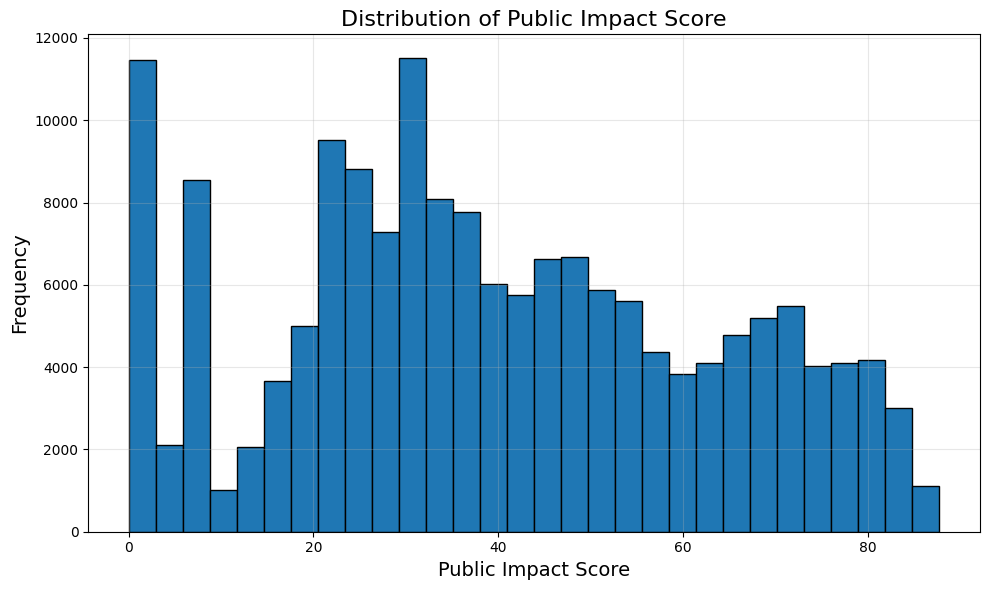

In [ ]:
import matplotlib.pyplot as plt

# ดึงคอลัมน์ public_impact ออกมาเป็น Pandas Series
public_impact_values = gdf_public_impact.select("public_impact").toPandas()["public_impact"]

plt.figure(figsize=(10,6))
plt.hist(
    public_impact_values,
    bins=30,
    edgecolor="black"
)
plt.title("Distribution of Public Impact Score", fontsize=16)
plt.xlabel("Public Impact Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import functions as F

# คำนวณ skewness ของคอลัมน์ public_impact
skew_value = gdf_public_impact.select(F.skewness("public_impact")).collect()[0][0]

print(skew_value)


0.12841943411698098


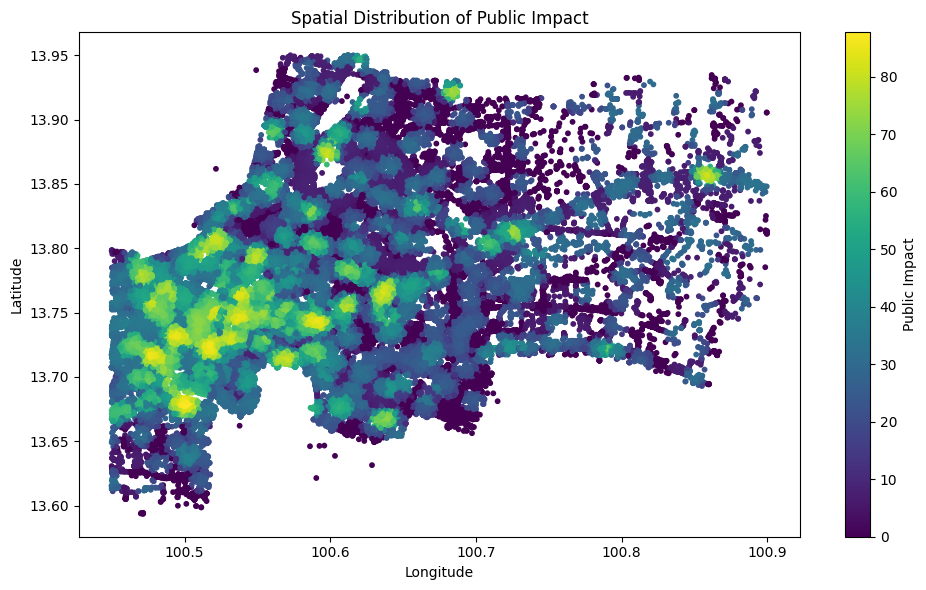

In [ ]:
import matplotlib.pyplot as plt

# แปลง Spark DataFrame เป็น Pandas DataFrame (ถ้า dataset ใหญ่ให้ sample)
pdf = gdf_public_impact.select("lon", "lat", "public_impact").toPandas()
plt.figure(figsize=(10,6))
plt.scatter(
    pdf["lon"],
    pdf["lat"],
    c=pdf["public_impact"],
    cmap="viridis",
    s=10
)
plt.colorbar(label="Public Impact")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Public Impact")
plt.tight_layout()
plt.show()


In [ ]:
# ลบคอลัมน์ geometry
df_export = gdf_public_impact

# เขียนเป็น CSV
df_export.write.csv("gdf_public_impact.csv", header=True, mode="overwrite")



In [ ]:
# gdf_public_impact.to_file("gdf_public_impact.geojson", driver="GeoJSON")

In [ ]:
df_from_file = spark.read.csv("gdf_public_impact.csv", header=True, inferSchema=True)
df_from_file.printSchema()
df_from_file.show(5)